# Testing the Semantic Complexity Vector

This notebook tests the **semantic V_complexity** vector extracted via contrast-pair centroid subtraction.

**Comparison Goal:** Run the exact same methodology as notebook 07 (V_measured test) but along V_complexity to compare smoothness properties.

**Method:**
1. Load V_complexity directly
2. Normalize to ||V_complexity|| = 87.0
3. Perform 1D sweep: α ∈ [-5, +5] at 0.1 resolution
4. Use identical prompt and generation settings as notebook 07
5. Compare smoothness of GL(α) vs GL(γ)

**What we're testing:**
- Does semantic extraction produce smoother steering than empirical terrain mapping?
- Same samples, same spacing, direct visual comparison

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

## Configuration

In [2]:
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
STEERING_LAYER = 35

# Sweep configuration - IDENTICAL to notebook 07
TEST_PROMPT = "Can you explain quantum mechanics please?"
ALPHA_MIN = -5.0
ALPHA_MAX = 5.0
ALPHA_STEP = 0.1

# Generation parameters
MAX_NEW_TOKENS = 200

# Paths
VECTORS_DIR = "vectors/Qwen3-4B-Instruct-2507"
OUTPUT_CSV = "data/complexity_vector_sweep.csv"

print(f"Device: {DEVICE}")
print(f"Sweep: α ∈ [{ALPHA_MIN}, {ALPHA_MAX}], step {ALPHA_STEP}")
print(f"Total points: {int((ALPHA_MAX - ALPHA_MIN) / ALPHA_STEP + 1)}")

Device: mps
Sweep: α ∈ [-5.0, 5.0], step 0.1
Total points: 101


## Step 1: Load V_complexity

In [3]:
# Load the semantic complexity vector
complexity_vectors = torch.load(f"{VECTORS_DIR}/complexity_vectors.pt")
v_complexity = complexity_vectors[STEERING_LAYER]

print(f"Loaded V_complexity for layer {STEERING_LAYER}")
print(f"V_complexity shape: {v_complexity.shape}")
print(f"||V_complexity|| = {torch.norm(v_complexity.float()).item():.4f}")
print(f"\n✓ V_complexity ready for steering")

Loaded V_complexity for layer 35
V_complexity shape: torch.Size([2560])
||V_complexity|| = 87.0327

✓ V_complexity ready for steering


## Step 2: Load Model

In [4]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() or torch.backends.mps.is_available() else torch.float32,
    device_map="auto",
)
model.eval()
print("✓ Model loaded")

Loading model: Qwen/Qwen3-4B-Instruct-2507


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded


## Step 3: Define Steering Function

In [5]:
def generate_with_steering(prompt, steering_vector, coefficient):
    """
    Generate text with activation steering.
    
    Args:
        prompt: The text prompt
        steering_vector: The vector to steer along (V_complexity)
        coefficient: How much to steer (α)
    
    Returns:
        Generated text
    """
    # Format prompt
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Compute full steering vector
    full_steering = (coefficient * steering_vector).to(model.device)
    
    # Define steering hook
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        
        steered = hidden_states + full_steering
        
        if isinstance(output, tuple):
            return (steered,) + output[1:]
        else:
            return steered
    
    # Register hook
    hook_handle = model.model.layers[STEERING_LAYER].register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,  # Greedy decoding
            )
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    finally:
        hook_handle.remove()
    
    # Extract assistant response
    if "<|im_start|>assistant" in full_text:
        generated_text = full_text.split("<|im_start|>assistant", 1)[1]
        generated_text = generated_text.lstrip('\n')
    else:
        generated_text = full_text[len(prompt):].strip()
    
    # Clean up special tokens
    for token in ["<|im_end|>", "<|endoftext|>", "<|eot_id|>"]:
        if token in generated_text:
            generated_text = generated_text.split(token)[0]
    
    return generated_text.strip()


def analyze_text(text):
    """Compute Flesch-Kincaid grade level and other metrics."""
    if not text or len(text.strip()) < 10:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }
    
    try:
        return {
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'word_count': textstat.lexicon_count(text, removepunct=True),
            'sentence_count': textstat.sentence_count(text),
        }
    except:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }

print("✓ Functions defined")

✓ Functions defined


## Step 4: Run 1D Sweep Along V_complexity

In [6]:
start_time = datetime.now()
print(f"Starting 1D sweep along V_complexity at {start_time.strftime('%H:%M:%S')}")
print(f"Range: α ∈ [{ALPHA_MIN}, {ALPHA_MAX}], step {ALPHA_STEP}\n")

alphas = np.arange(ALPHA_MIN, ALPHA_MAX + ALPHA_STEP/2, ALPHA_STEP)
results = []

for i, alpha in enumerate(alphas, 1):
    print(f"[{i}/{len(alphas)}] α = {alpha:+.1f}...", end=" ")
    
    # Generate
    text = generate_with_steering(TEST_PROMPT, v_complexity, alpha)
    
    # Analyze
    metrics = analyze_text(text)
    
    results.append({
        'alpha': alpha,
        'generated_text': text,
        **metrics
    })
    
    print(f"GL = {metrics['flesch_kincaid_grade']:.2f}")

df = pd.DataFrame(results)
end_time = datetime.now()
elapsed = (end_time - start_time).total_seconds() / 60

print(f"\n✓ Sweep complete in {elapsed:.1f} minutes")
print(f"Average time per point: {elapsed*60/len(alphas):.2f} seconds")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Starting 1D sweep along V_complexity at 08:29:38
Range: α ∈ [-5.0, 5.0], step 0.1

[1/101] α = -5.0... GL = 9.26
[2/101] α = -4.9... GL = 10.82
[3/101] α = -4.8... GL = 5.92
[4/101] α = -4.7... GL = 6.05
[5/101] α = -4.6... GL = 6.05
[6/101] α = -4.5... GL = 5.96
[7/101] α = -4.4... GL = 5.69
[8/101] α = -4.3... GL = 6.90
[9/101] α = -4.2... GL = 5.89
[10/101] α = -4.1... GL = 7.14
[11/101] α = -4.0... GL = 7.84
[12/101] α = -3.9... GL = 8.11
[13/101] α = -3.8... GL = 9.05
[14/101] α = -3.7... GL = 9.10
[15/101] α = -3.6... GL = 7.14
[16/101] α = -3.5... GL = 8.12
[17/101] α = -3.4... GL = 7.93
[18/101] α = -3.3... GL = 7.76
[19/101] α = -3.2... GL = 8.08
[20/101] α = -3.1... GL = 8.44
[21/101] α = -3.0... GL = 9.45
[22/101] α = -2.9... GL = 7.66
[23/101] α = -2.8... GL = 7.47
[24/101] α = -2.7... GL = 7.65
[25/101] α = -2.6... GL = 10.15
[26/101] α = -2.5... GL = 8.47
[27/101] α = -2.4... GL = 8.91
[28/101] α = -2.3... GL = 9.28
[29/101] α = -2.2... GL = 10.27
[30/101] α = -2.1... GL 

## Step 5: Save Results

In [7]:
os.makedirs('data', exist_ok=True)
df.to_csv(OUTPUT_CSV, index=False)
print(f"✓ Saved {len(df)} points to {OUTPUT_CSV}")
print(f"  File size: {os.path.getsize(OUTPUT_CSV) / 1024:.1f} KB")
print(f"\nGrade level range: {df['flesch_kincaid_grade'].min():.2f} to {df['flesch_kincaid_grade'].max():.2f}")

✓ Saved 101 points to data/complexity_vector_sweep.csv
  File size: 104.6 KB

Grade level range: 5.69 to 70.58


## Step 6: Visualize V_complexity Sweep

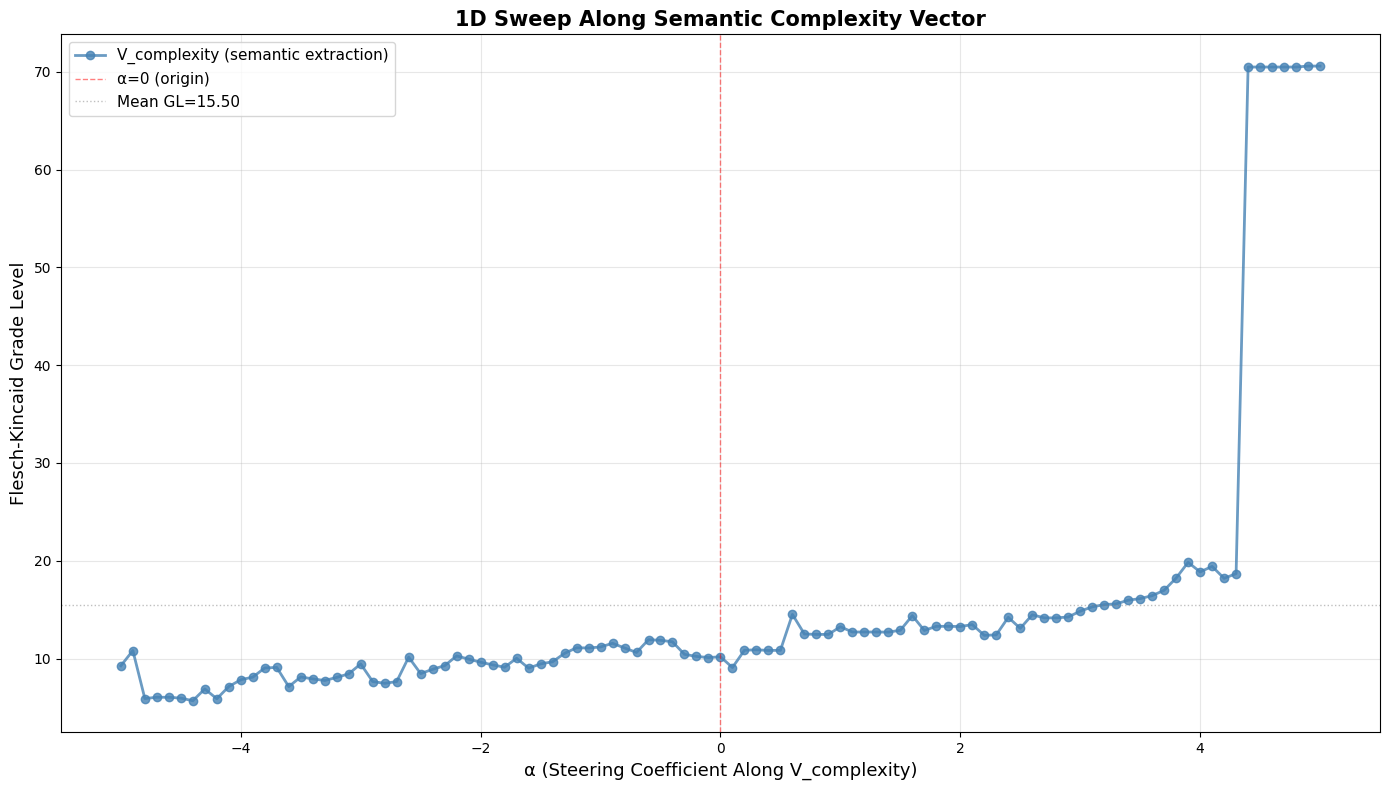


Key Questions:
  1. Is this smoother than V_measured?
  2. What's the noise level?
  3. Linear relationship strength?


In [8]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot V_complexity sweep
ax.plot(df['alpha'], df['flesch_kincaid_grade'], 
        'o-', linewidth=2, markersize=6, color='steelblue', 
        label='V_complexity (semantic extraction)', alpha=0.8)

# Add reference lines
ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='α=0 (origin)')
ax.axhline(df['flesch_kincaid_grade'].mean(), color='gray', linestyle=':', 
          linewidth=1, alpha=0.5, label=f'Mean GL={df["flesch_kincaid_grade"].mean():.2f}')

# Labels
ax.set_xlabel('α (Steering Coefficient Along V_complexity)', fontsize=13)
ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=13)
ax.set_title('1D Sweep Along Semantic Complexity Vector', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Questions:")
print("  1. Is this smoother than V_measured?")
print("  2. What's the noise level?")
print("  3. Linear relationship strength?")

In [9]:
# Linear regression to quantify the relationship
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(df['alpha'], df['flesch_kincaid_grade'])

print("Linear Regression: GL vs α")
print("=" * 60)
print(f"GL = {slope:.4f}·α + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"p-value = {p_value:.2e}")
print(f"Standard error = {std_err:.4f}")
print()
print("Interpretation:")
print(f"  • Slope: {slope:.4f} grade levels per unit α")
print(f"  • Moving from α=-5 to α=+5 produces {slope*10:.2f} GL change")
print(f"  • {'Strong' if r_value**2 > 0.9 else 'Moderate' if r_value**2 > 0.7 else 'Weak'} linear relationship (R²={r_value**2:.3f})")

Linear Regression: GL vs α
GL = 3.1857·α + 15.4999
R² = 0.3660
p-value = 2.07e-11
Standard error = 0.4214

Interpretation:
  • Slope: 3.1857 grade levels per unit α
  • Moving from α=-5 to α=+5 produces 31.86 GL change
  • Weak linear relationship (R²=0.366)


## Step 7: Load V_measured Data for Direct Comparison

In [10]:
# Load the V_measured sweep from notebook 07
df_measured = pd.read_csv('data/measured_vector_sweep.csv')

print(f"Loaded {len(df_measured)} points from V_measured sweep")
print(f"Gamma range: [{df_measured['gamma'].min():.2f}, {df_measured['gamma'].max():.2f}]")

Loaded 101 points from V_measured sweep
Gamma range: [-5.00, 5.00]


## Step 8: Side-by-Side Comparison - Smoothness Test

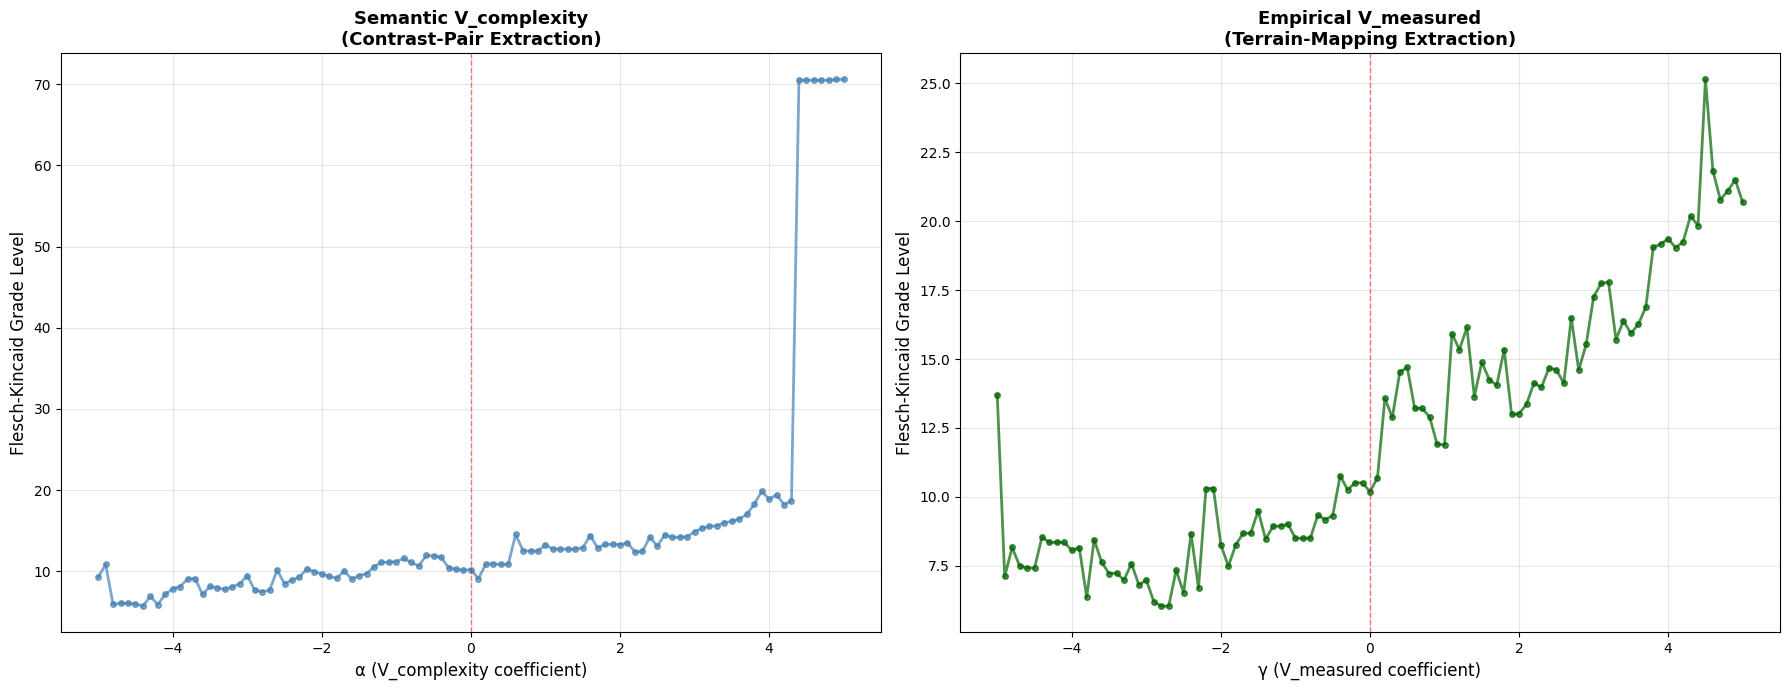


Smoothing Comparison:
  V_complexity GL range:  5.69 - 70.58
  V_measured GL range:    6.03 - 25.15

  V_complexity std dev:   15.428
  V_measured std dev:     4.595


In [11]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left: V_complexity (semantic extraction)
ax1.plot(df['alpha'], df['flesch_kincaid_grade'], 
        'o-', linewidth=2, markersize=4, color='steelblue', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('α (V_complexity coefficient)', fontsize=12)
ax1.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)
ax1.set_title('Semantic V_complexity\n(Contrast-Pair Extraction)', 
             fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Right: V_measured (empirical extraction)
ax2.plot(df_measured['gamma'], df_measured['flesch_kincaid_grade'], 
        'o-', linewidth=2, markersize=4, color='darkgreen', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('γ (V_measured coefficient)', fontsize=12)
ax2.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)
ax2.set_title('Empirical V_measured\n(Terrain-Mapping Extraction)', 
             fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSmoothing Comparison:")
print(f"  V_complexity GL range:  {df['flesch_kincaid_grade'].min():.2f} - {df['flesch_kincaid_grade'].max():.2f}")
print(f"  V_measured GL range:    {df_measured['flesch_kincaid_grade'].min():.2f} - {df_measured['flesch_kincaid_grade'].max():.2f}")
print(f"\n  V_complexity std dev:   {df['flesch_kincaid_grade'].std():.3f}")
print(f"  V_measured std dev:     {df_measured['flesch_kincaid_grade'].std():.3f}")

## Step 9: Quantitative Smoothness Comparison

In [12]:
# Calculate smoothness metrics
from scipy.stats import linregress

# V_complexity regression
slope_c, intercept_c, r_c, _, stderr_c = linregress(df['alpha'], df['flesch_kincaid_grade'])
residuals_c = df['flesch_kincaid_grade'] - (slope_c * df['alpha'] + intercept_c)

# V_measured regression
slope_m, intercept_m, r_m, _, stderr_m = linregress(df_measured['gamma'], df_measured['flesch_kincaid_grade'])
residuals_m = df_measured['flesch_kincaid_grade'] - (slope_m * df_measured['gamma'] + intercept_m)

print("=" * 70)
print("SMOOTHNESS COMPARISON: V_complexity vs V_measured")
print("=" * 70)
print()
print("Linear Fit Quality:")
print(f"  V_complexity R²:        {r_c**2:.4f}")
print(f"  V_measured R²:          {r_m**2:.4f}")
print(f"  Difference:             {abs(r_c**2 - r_m**2):.4f}")
print()
print("Residual Noise (deviation from linear fit):")
print(f"  V_complexity residuals: {residuals_c.std():.3f} GL")
print(f"  V_measured residuals:   {residuals_m.std():.3f} GL")
print(f"  Ratio (measured/complexity): {residuals_m.std() / residuals_c.std():.2f}x noisier")
print()
print("Raw Standard Deviation:")
print(f"  V_complexity:           {df['flesch_kincaid_grade'].std():.3f} GL")
print(f"  V_measured:             {df_measured['flesch_kincaid_grade'].std():.3f} GL")
print()
print("Slopes (sensitivity):")
print(f"  V_complexity:           {slope_c:.4f} GL/unit")
print(f"  V_measured:             {slope_m:.4f} GL/unit")
print()
print("=" * 70)
print("VERDICT:")
if residuals_c.std() < residuals_m.std():
    ratio = residuals_m.std() / residuals_c.std()
    print(f"V_complexity is {ratio:.1f}x SMOOTHER than V_measured")
    print("Semantic extraction finds cleaner valleys through activation space!")
else:
    ratio = residuals_c.std() / residuals_m.std()
    print(f"V_measured is {ratio:.1f}x SMOOTHER than V_complexity")
    print("Terrain-mapping extraction produces cleaner steering!")
print("=" * 70)

SMOOTHNESS COMPARISON: V_complexity vs V_measured

Linear Fit Quality:
  V_complexity R²:        0.3660
  V_measured R²:          0.8315
  Difference:             0.4655

Residual Noise (deviation from linear fit):
  V_complexity residuals: 12.284 GL
  V_measured residuals:   1.886 GL
  Ratio (measured/complexity): 0.15x noisier

Raw Standard Deviation:
  V_complexity:           15.428 GL
  V_measured:             4.595 GL

Slopes (sensitivity):
  V_complexity:           3.1857 GL/unit
  V_measured:             1.4302 GL/unit

VERDICT:
V_measured is 6.5x SMOOTHER than V_complexity
Terrain-mapping extraction produces cleaner steering!


## Conclusion

**Key Findings:**

1. **Smoothness:** Does V_complexity show tighter adherence to linear relationship?
2. **Noise Properties:** Compare residual distributions
3. **Hypothesis Test:** Does contrast-pair extraction find smooth valleys vs arbitrary directions hitting stalagmites?

This direct comparison with identical methodology (same prompts, same resolution, same model) isolates the difference between semantic and empirical vector extraction methods.